In [11]:
import sqlite3
import re
import string
import unicodedata
import itertools
from collections import Counter 
from itertools import chain

# Veri Analizi ve Görselleştirme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stylecloud 

# Görüntü İşleme
import PIL.ImageDraw 
# Doğal Dil İşleme (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from snowballstemmer import TurkishStemmer, stemmer
from zemberek import TurkishMorphology

# Ağ Analizi
import networkx as nx

In [12]:
conn=sqlite3.connect("ai_data.db")

In [13]:
query = """
SELECT 'Chatgpt' as Kaynak, felsefi_yapayzeka, duygusal_motivasyon, kariyer_gelisim FROM Chatgpt
UNION ALL
SELECT 'Deepseek' as Kaynak, felsefi_yapayzeka, duygusal_motivasyon, kariyer_gelisim FROM Deepseek
UNION ALL
SELECT 'Gemini' as Kaynak, felsefi_yapayzeka, duygusal_motivasyon, kariyer_gelisim FROM Gemini;
"""
df = pd.read_sql_query(query, conn)
conn.close()
print(df.head())

    Kaynak                                  felsefi_yapayzeka  \
0  Chatgpt  Hayatın anlamı, kişisel hedefler ve değerler d...   
1  Chatgpt  İnsan özgürlüğü, seçim yapabilme kapasitesiyle...   
2  Chatgpt  Mutluluk, tatmin, huzur ve anlamlı deneyimleri...   
3  Chatgpt  Yapay zekâ bazı görevlerde insan performansını...   
4  Chatgpt  Sorgulama, öğrenme ve evreni anlamlandırma iht...   

                                 duygusal_motivasyon  \
0  Küçük adımlar atmak ve ilerlemeyi görmek, umut...   
1  Hatalarından ders çıkar ve çözüm yollarına oda...   
2  Sevgi, kendini değerli ve güvende hissetmeni s...   
3  Sen gücünü daha önce gösterdin; şimdi sırada b...   
4  Kendine zaman ayır, nefes al ve seni mutlu ede...   

                                     kariyer_gelisim  
0  Pozitif bir tutum sergile, hazırlıklı ol ve ke...  
1  Temel bilgilerle başlayıp pratik projeler yapa...  
2  Başarısızlık, eksikliklerimizi görmemizi sağla...  
3  Hedefler belirle, ilerlemeyi takip et ve başar...

In [14]:
df["felsefi_yapayzeka"]

0     Hayatın anlamı, kişisel hedefler ve değerler d...
1     İnsan özgürlüğü, seçim yapabilme kapasitesiyle...
2     Mutluluk, tatmin, huzur ve anlamlı deneyimleri...
3     Yapay zekâ bazı görevlerde insan performansını...
4     Sorgulama, öğrenme ve evreni anlamlandırma iht...
5     İnsan zihni sonlu deneyimlere ve sınırlı algıy...
6     İnsan doğası karmaşıktır; hem empati ve iyilik...
7     AI, programlandığı kurallara göre karar verebi...
8     Zaman, insan deneyimi ve evrenin düzenini anla...
9     İnsan ve teknoloji etkileşimi daha entegre ve ...
10    Öznel bir kavramdır; her birey kendi amacını, ...
11    Determinizm ve özgür irade tartışması vardır; ...
12    Anlamlı bir yaşam sürme, amaç sahibi olma ve i...
13    Belirli görevlerde (hesaplama, veri analizi) ç...
14    Doğuştan gelen bir merak, belirsizliği azaltma...
15    İnsan zihni sonlu deneyimler ve zaman kavramı ...
16    İkisi de içgüdüseldir; sosyal işbirliği (iyili...
17    Programlanmış etik kurallara ve verilere d

In [15]:
kok_bul=stemmer("turkish")
print(kok_bul.stemWords("hayatlar".split()))


['hayat']


In [16]:
morphology = TurkishMorphology.create_with_defaults()
nltk_stop_words= set(stopwords.words('turkish'))
noktalama_isaret = string.punctuation
cevirme_tablosu = str.maketrans("", "", noktalama_isaret)


2026-02-01 21:13:42,578 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 5.026734352111816



In [17]:
ek_stop_words= set(['bu', 'şu', 'o', 'hem', 'tüm', 'ancak', 'yani', 'göre', 'eğer', 
    'bunu', 'şunu', 'buna', 'şuna', 'olmak', 'ol',"bir","mi", "etmek"])
stop_words=nltk_stop_words.union(ek_stop_words)

In [18]:
kok_bul=TurkishStemmer()

In [19]:
def nlp_temizlik_akisi(metin_listesi):
    temiz_kokler = []
    hatali_kokler = {
        "değ": "değer", "doğ": "doğa", "seçi": "seçim", 
        "zihni": "zihin", "karmak": "karmaşık", "evre": "evren", 'stratej':"strateji"
    }
    
    ayrilmaz = {
        "yapay zeka": "yapay_zeka",
        "insan doga": "insan_dogasi", 
        "karar ver": "karar_verme",
        "gunluk yasam": "gunluk_yasam"
    }

    for metin in metin_listesi:
        metin = str(metin).lower().replace("i̇", "i")
        metin = metin.replace("î", "i").replace("â", "a").replace("û", "u")
        metin = metin.replace("\u0302", "") 
        
        metin = metin.translate(cevirme_tablosu)
        
        gecici_satir_kokleri = []
        
        for kelime in metin.split():
            analiz = morphology.analyze(kelime)
            
            if analiz.analysis_results:
                kok = analiz.analysis_results[0].item.lemma.lower()
                kok = kok.replace("î", "i").replace("â", "a").replace("\u0302", "").replace("i̇", "i")

                if kok in hatali_kokler:
                    kok = hatali_kokler[kok]

                if kok not in stop_words and kok != "bir" and len(kok) > 1:
                    gecici_satir_kokleri.append(kok)
            else:

                if kelime not in stop_words and kelime != "bir" and len(kelime) > 1:
                    gecici_satir_kokleri.append(kelime)

        satir_metni = " ".join(gecici_satir_kokleri)
        for anahtar, deger in ayrilmaz.items():
            satir_metni = satir_metni.replace(anahtar, deger)
        
        temiz_kokler.extend(satir_metni.split())
        
    return temiz_kokler


In [20]:
felsefi = nlp_temizlik_akisi(df["felsefi_yapayzeka"])
print(felsefi)

['hayat', 'anlam', 'kişisel', 'hedeflemek', 'değmek', 'doğrultu', 'kendi', 'gerçek', 'insan', 'özgürlük', 'seçim', 'yapmak', 'kapasite', 'sınır', 'koşullamak', 'çevre', 'özgürlük', 'etkilemek', 'mutlu', 'tatmin', 'huzur', 'anlam', 'deneyim', 'birleşim', 'orta', 'çıkmak', 'yapay_zeka', 'görev', 'insan', 'performans', 'aşmak', 'fakat', 'duygu', 'etik', 'karmaşık', 'insan', 'seviye', 'sınır', 'sorgulamak', 'öğrenmek', 'evren', 'anlamlanmak', 'ihtiyaç', 'kaynaklanmak', 'insan', 'zihin', 'sonlu', 'deneyim', 'sınır', 'algı', 'sahip', 'sonsuz', 'kavramak', 'zor', 'insan', 'doğmak', 'karmaşık', 'empati', 'iyi', 'bencil', 'eğilim', 'taşımak', 'ai', 'programlamak', 'kural', 'karmaşık', 'vermek', 'insan', 'ahlak', 'nüans', 'anlamak', 'zaman', 'insan', 'deney', 'evren', 'düzen', 'anlamak', 'kullanmak', 'kavram', 'insan', 'teknoloji', 'etkileşim', 'entegre', 'desteklemek', 'yapay_zeka', 'günlük', 'yaşam', 'vazgeçilmez', 'parça', 'hal', 'gelecek', 'öznel', 'kavram', 'birey', 'kendi', 'amaç', 'değer'

In [22]:
if not hasattr(PIL.ImageDraw.ImageDraw, 'textsize'):
    def textsize_fix(self, text, font=None, *args, **kwargs):
        bbox = self.textbbox((0, 0), text, font=font, *args, **kwargs)
        return bbox[2] - bbox[0], bbox[3] - bbox[1]
    PIL.ImageDraw.ImageDraw.textsize = textsize_fix


felsefi_kelimeler = Counter(felsefi)
word_freq_felsefi = dict(felsefi_kelimeler)

stylecloud.gen_stylecloud(
    text=word_freq_felsefi,
    icon_name='fas fa-brain',    
    palette='colorbrewer.diverging.Spectral_11',
    background_color='black',
    output_name='felsefi_bulut.png',
    collocations=False
)

print("felsefi_bulut.png")

felsefi_bulut.png


In [23]:
duygusal= nlp_temizlik_akisi(df["duygusal_motivasyon"])
kariyer=nlp_temizlik_akisi(df["kariyer_gelisim"])
word_freq_duygusal=Counter(duygusal)
word_freq_kariyer=Counter(kariyer)

In [24]:
stylecloud.gen_stylecloud(
    text=word_freq_duygusal,
    icon_name='fas fa-smile',    
    palette='cartocolors.qualitative.Pastel_10',
    background_color='black',
    output_name='duygusal_bulut.png',
    collocations=False 
)

In [25]:
stylecloud.gen_stylecloud(
    text=word_freq_kariyer,
    icon_name='fas fa-rocket',    
    palette='colorbrewer.sequential.Blues_9',
    background_color='black',
    output_name='kariyer_bulut.png',
    collocations=False 
)

In [27]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

from transformers import pipeline
sentiment_pipeline = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    framework="pt"
)



2.10.0+cpu
False


Device set to use cpu


In [28]:
def get_score(metin):

    if not metin or len(str(metin).strip()) < 2:
        return 0.5 
    

    sonuc = sentiment_pipeline(metin)[0]
    etiket = sonuc['label'].lower()
    skor = sonuc['score']

    if 'positive' in etiket:
        return skor
    elif 'negative' in etiket:
        return 1 - skor
    else:
        
        return 0.5

In [30]:
def roberta_icin_temizlik(metin):
    if metin is None: return ""
    metin = str(metin).lower()
    metin = metin.replace("i̇", "i").replace("î", "i").replace("â", "a").replace("û", "u")
    metin = metin.replace("\u0302", "")
    metin = re.sub(r'\s+', ' ', metin).strip()
    return metin


df["felsefi_temiz"] = df["felsefi_yapayzeka"].apply(roberta_icin_temizlik)
df["duygusal_temiz"] = df["duygusal_motivasyon"].apply(roberta_icin_temizlik)
df["kariyer_temiz"] = df["kariyer_gelisim"].apply(roberta_icin_temizlik)

df["felsefi_skor"] = df["felsefi_temiz"].apply(get_score)
df["duygusal_skor"] = df["duygusal_temiz"].apply(get_score)
df["kariyer_skor"] = df["kariyer_temiz"].apply(get_score)

analiz_sonuclari = df.groupby('Kaynak')[['felsefi_skor', 'duygusal_skor', 'kariyer_skor']].mean()
print(analiz_sonuclari)

          felsefi_skor  duygusal_skor  kariyer_skor
Kaynak                                             
Chatgpt       0.527579       0.670784      0.588749
Deepseek      0.483377       0.580893      0.535771
Gemini        0.495172       0.623673      0.571928


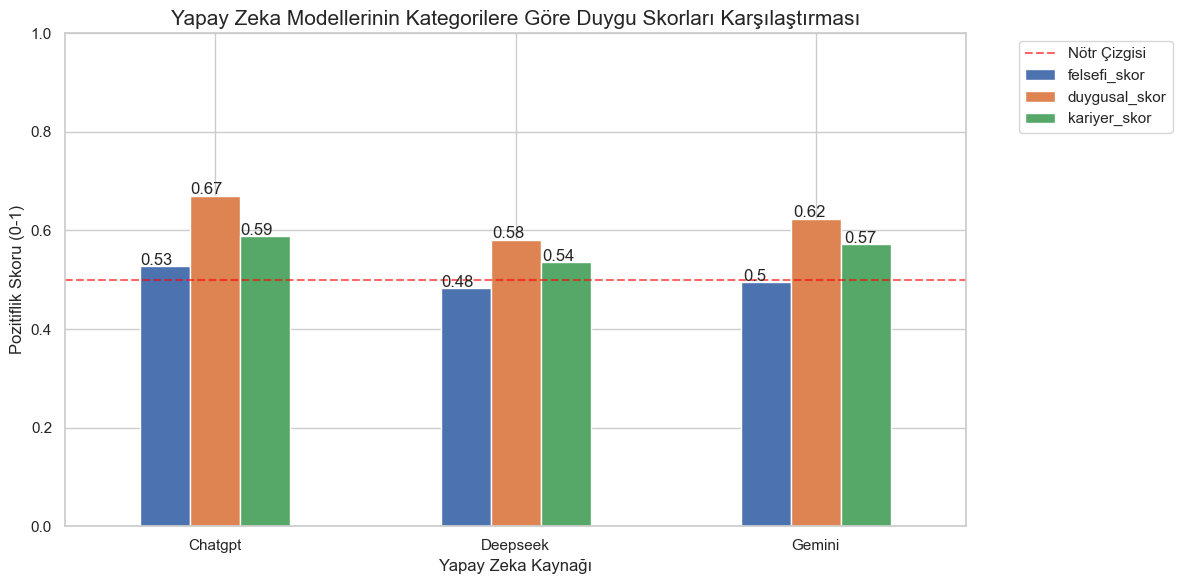

In [31]:
sns.set_theme(style="whitegrid")

ax = analiz_sonuclari.plot(kind='bar', figsize=(12, 6), rot=0)

plt.title('Yapay Zeka Modellerinin Kategorilere Göre Duygu Skorları Karşılaştırması', fontsize=15)
plt.ylabel('Pozitiflik Skoru (0-1)', fontsize=12)
plt.xlabel('Yapay Zeka Kaynağı', fontsize=12)
plt.ylim(0, 1) 
plt.axhline(0.5, color='red', linestyle='--', alpha=0.6, label='Nötr Çizgisi') # Nötr referans çizgisi

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

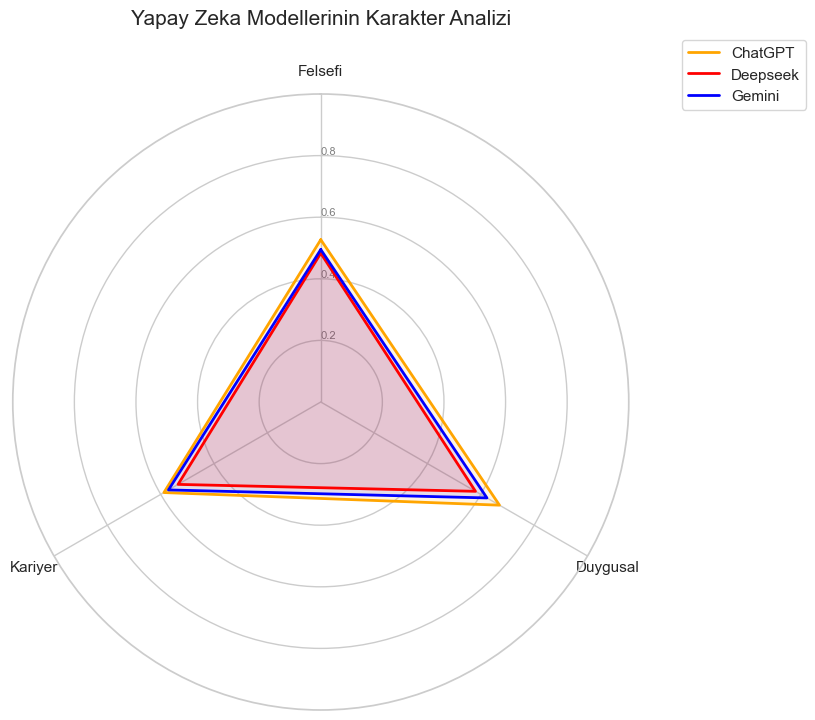

In [32]:
categories = ['Felsefi', 'Duygusal', 'Kariyer']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=8)
plt.ylim(0, 1)

models = {
    'ChatGPT': [0.527, 0.670, 0.588],
    'Deepseek': [0.483, 0.580, 0.535],
    'Gemini': [0.495, 0.623, 0.571]
}
colors = {'ChatGPT': 'orange', 'Deepseek': 'red', 'Gemini': 'blue'}

for model_name, values in models.items():
    v = values + values[:1]
    ax.plot(angles, v, linewidth=2, label=model_name, color=colors[model_name])
    ax.fill(angles, v, color=colors[model_name], alpha=0.1)

plt.title('Yapay Zeka Modellerinin Karakter Analizi', size=15, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

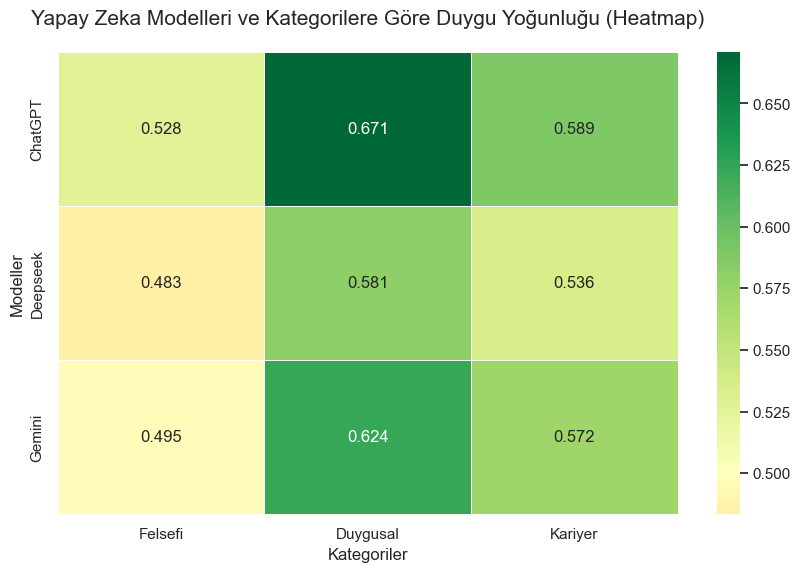

In [33]:
data = {
    'Felsefi': [0.527579, 0.483377, 0.495172],
    'Duygusal': [0.670784, 0.580893, 0.623673],
    'Kariyer': [0.588749, 0.535771, 0.571928]
}
index = ['ChatGPT', 'Deepseek', 'Gemini']
df_heatmap = pd.DataFrame(data, index=index)

plt.figure(figsize=(10, 6))

sns.heatmap(df_heatmap, annot=True, cmap='RdYlGn', center=0.5, fmt='.3f', linewidths=.5)

plt.title('Yapay Zeka Modelleri ve Kategorilere Göre Duygu Yoğunluğu (Heatmap)', fontsize=15, pad=20)
plt.xlabel('Kategoriler', fontsize=12)
plt.ylabel('Modeller', fontsize=12)

plt.show()

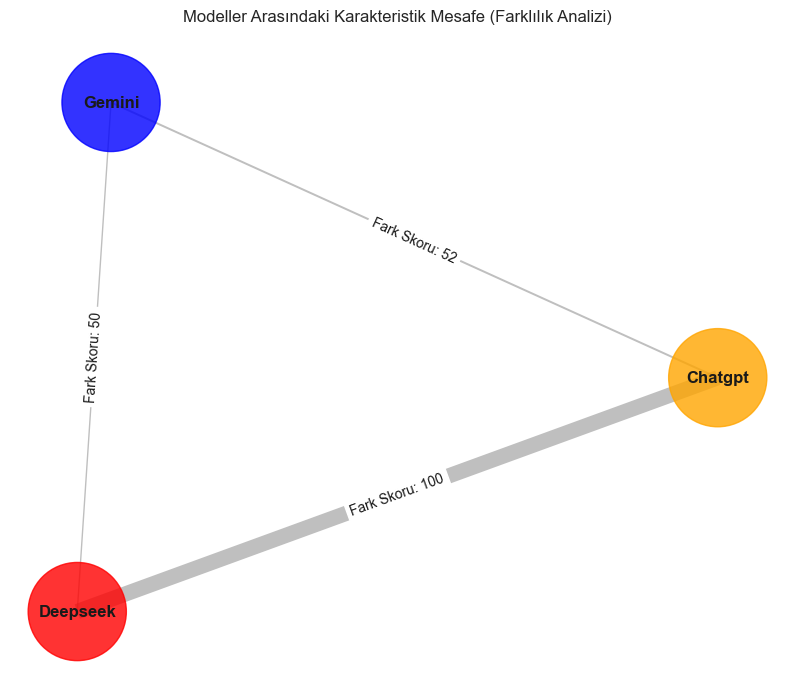

In [34]:
def mesafe_hesapla(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

modeller = analiz_sonuclari.index.tolist()
skorlar = analiz_sonuclari.values

G = nx.Graph()
farklar = []

for i in range(len(modeller)):
    for j in range(i + 1, len(modeller)):
        dist = mesafe_hesapla(skorlar[i], skorlar[j])
        G.add_edge(modeller[i], modeller[j], distance=dist)
        farklar.append(dist)

max_dist = max(farklar)
min_dist = min(farklar)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=2)

widths = [1 + (G[u][v]['distance'] - min_dist) / (max_dist - min_dist) * 10 for u, v in G.edges()]


nx.draw_networkx_nodes(G, pos, node_size=5000, node_color=['orange', 'red', 'blue'], alpha=0.8)
nx.draw_networkx_edges(G, pos, width=widths, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

edge_labels = {(u, v): f"Fark Skoru: {int((G[u][v]['distance'] / max_dist) * 100)}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Modeller Arasındaki Karakteristik Mesafe (Farklılık Analizi)", pad=20)
plt.axis('off')
plt.show()

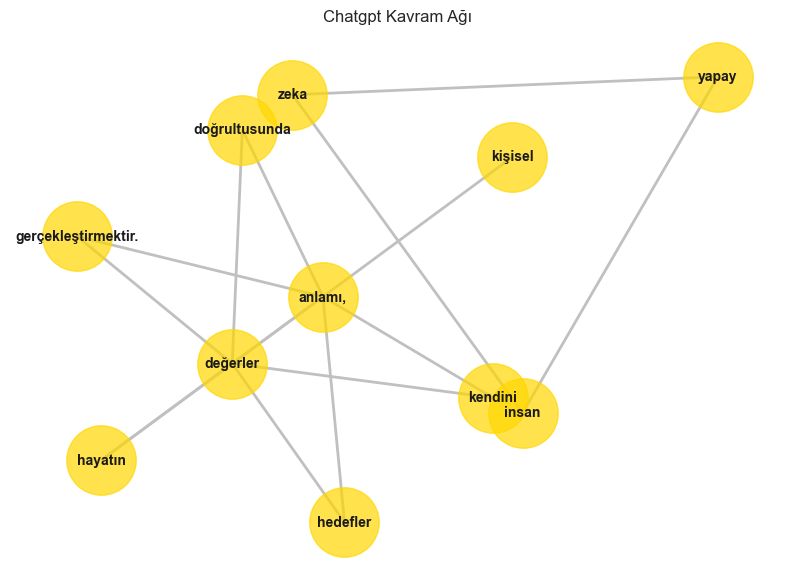

In [35]:
def model_kelime_agi_final(df, kategori, model_adi, limit=15):
    texts = df[df['Kaynak'].str.lower() == model_adi.lower()][kategori].dropna().tolist()
    
    pair_counts = Counter()
    for text in texts:
        words = [w.strip() for w in str(text).split() if len(w) > 3]
        unique_words = sorted(list(set(words)))
        if len(unique_words) > 1:
            for pair in itertools.combinations(unique_words, 2):
                pair_counts[pair] += 1

    if not pair_counts:
        print(f"Hata: {model_adi} ismiyle eşleşen veri bulunamadı. Lütfen 'Chatgpt' olarak deneyin.")
        return

    G = nx.Graph()
    for (w1, w2), count in pair_counts.most_common(limit):
        G.add_edge(w1, w2, weight=count)

    plt.figure(figsize=(10, 7))
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='gold', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=2, edge_color='silver')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title(f"{model_adi} Kavram Ağı")
    plt.axis('off')
    plt.show()

model_kelime_agi_final(df, 'felsefi_temiz', 'Chatgpt')

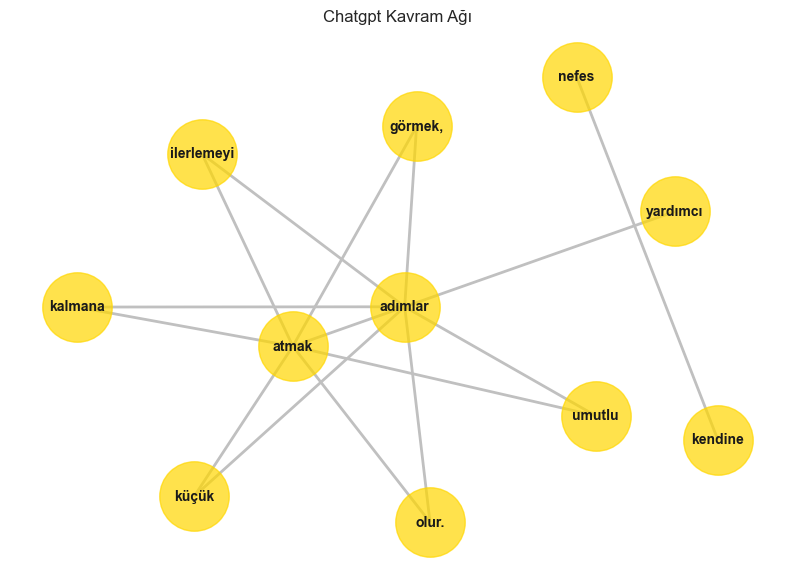

In [60]:
model_kelime_agi_final(df, 'duygusal_temiz', 'Chatgpt')

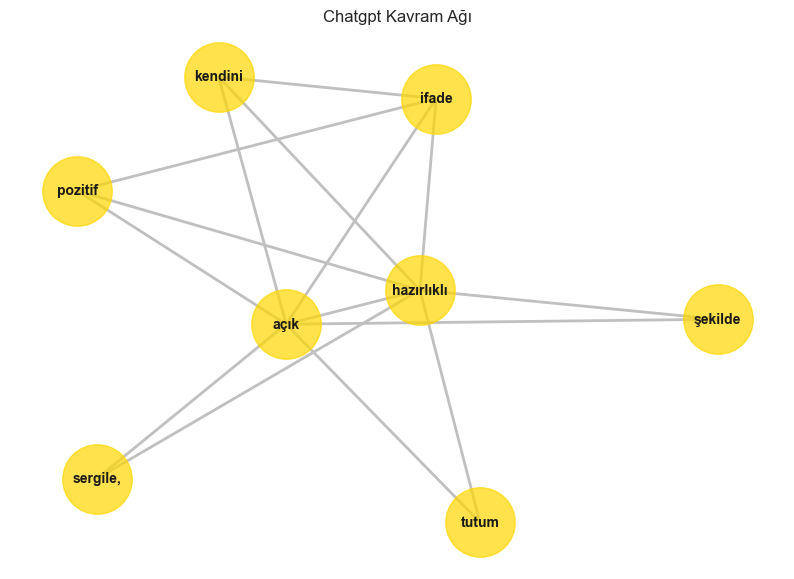

In [61]:
model_kelime_agi_final(df, 'kariyer_temiz', 'Chatgpt')

In [36]:
def ciz_ortak_kelime_agi(df, kategori, top_n=30):
    G = nx.Graph()
    kaynaklar = df['Kaynak'].unique()
    renk_haritasi = {'Chatgpt': 'orange', 'Deepseek': 'red', 'Gemini': 'blue'}
    
    for model in kaynaklar:
        texts = df[df['Kaynak'] == model][kategori].dropna().tolist()
        pair_counts = Counter()
        
        for text in texts:
            words = [w.strip() for w in str(text).split() if len(w) > 3]
            if len(words) > 1:
                for pair in itertools.combinations(sorted(set(words)), 2):
                    pair_counts[pair] += 1
        
        for (w1, w2), count in pair_counts.most_common(top_n // len(kaynaklar)):
            if G.has_edge(w1, w2):
                G[w1][w2]['weight'] += count
                G[w1][w2]['color'] = 'purple' 
            else:
                G.add_edge(w1, w2, weight=count, color=renk_haritasi.get(model, 'gray'))

    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=0.6, iterations=50)

    edges = G.edges()
    colors = [G[u][v]['color'] for u, v in edges]
    weights = [G[u][v]['weight'] for u, v in edges]
    max_w = max(weights) if weights else 1

    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightgray', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=[(w/max_w)*6 for w in weights], alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='orange', lw=2, label='Chatgpt Özgün'),
                       Line2D([0], [0], color='red', lw=2, label='Deepseek Özgün'),
                       Line2D([0], [0], color='blue', lw=2, label='Gemini Özgün'),
                       Line2D([0], [0], color='purple', lw=4, label='Ortak Kavramlar')]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(f"Modeller Arası Ortak ve Özgün Kavram Ağı: {kategori}", fontsize=16)
    plt.axis('off')
    plt.show()


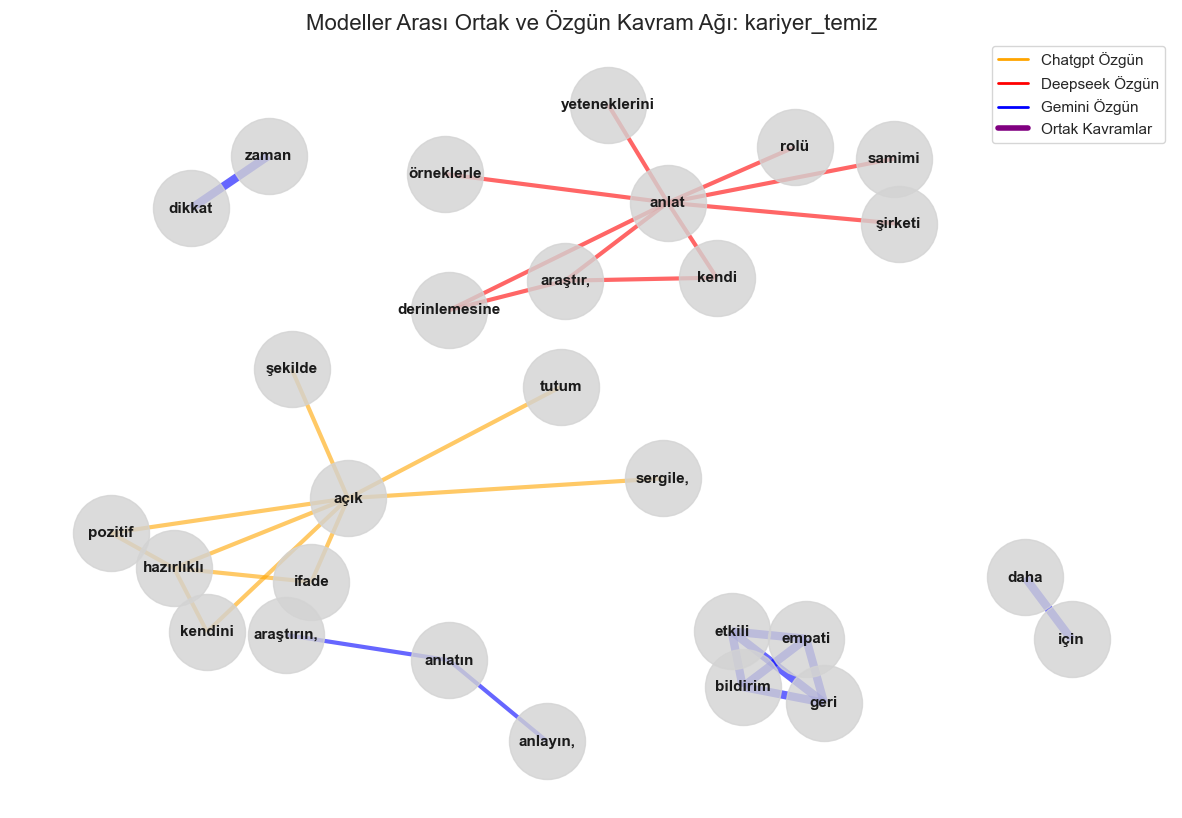

In [66]:
ciz_ortak_kelime_agi(df, 'kariyer_temiz')

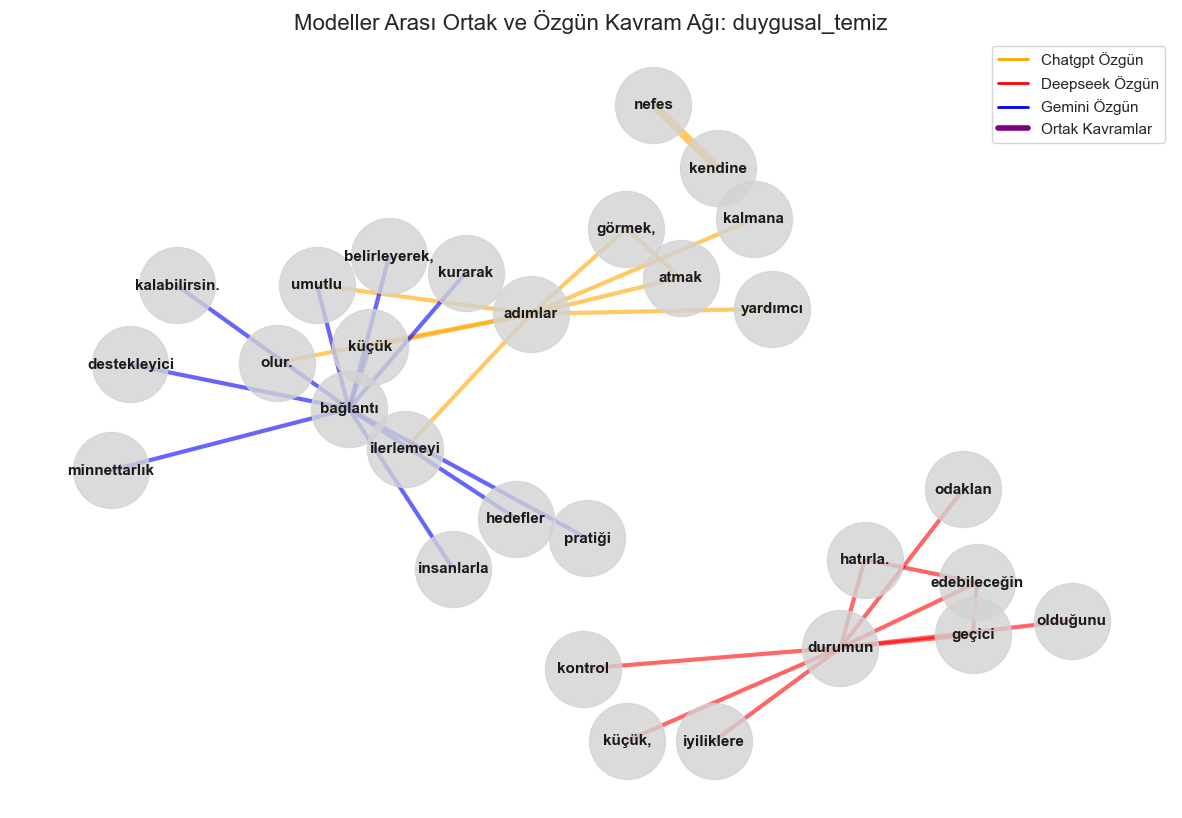

In [67]:
ciz_ortak_kelime_agi(df, 'duygusal_temiz')

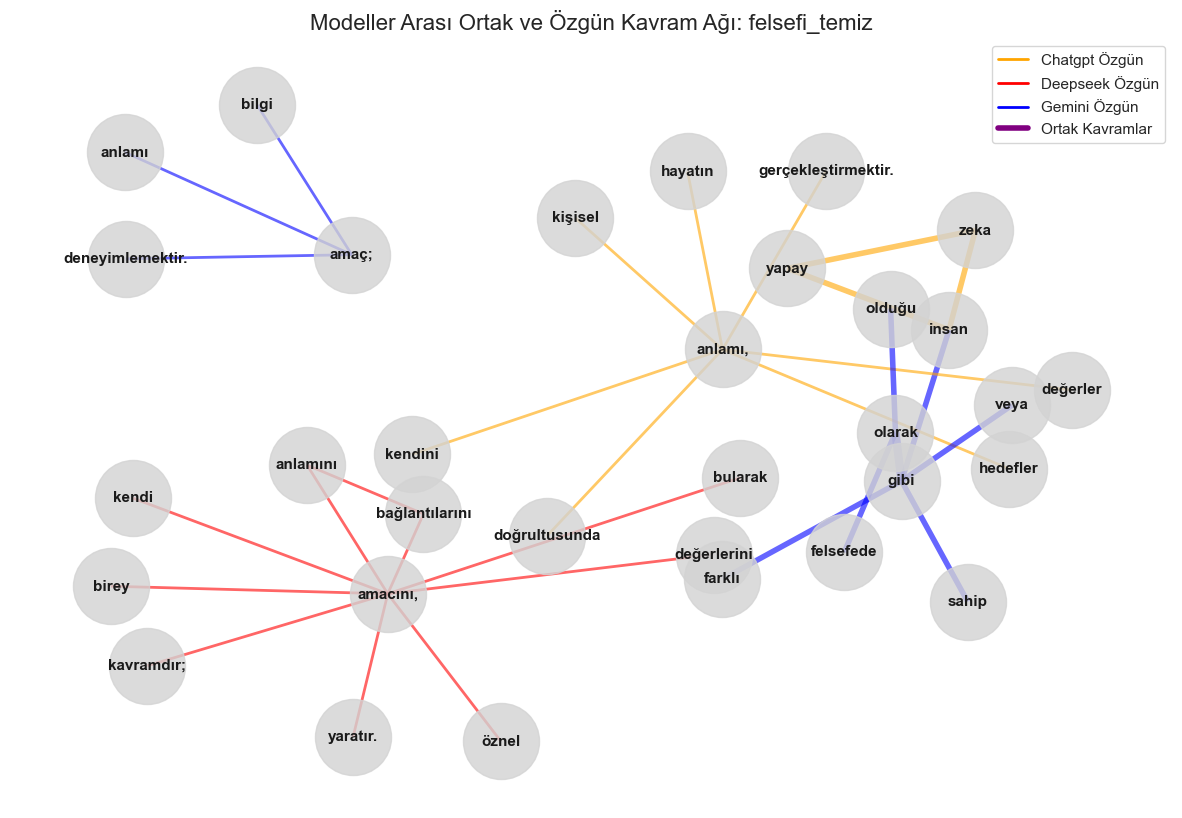

In [69]:
ciz_ortak_kelime_agi(df, 'felsefi_temiz')